In [1]:
import os
os.chdir('C:/Users/clack/Projects/nwm')

import torch
import torchvision
import torchvision.transforms as transforms
from typing import Callable


transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
def denormalize(tensor, mean=0.5, std=0.5):
    return tensor * std + mean

class OnDemandDataset(torchvision.datasets.VisionDataset):
  def __init__(self, size: int, sample: Callable[[], torch.Tensor], transform = None):
    super().__init__(transform=transform)
    self.size = size
    self.sample = sample

  def __len__(self):
    return self.size
  
  def __getitem__(self, _) -> torch.Tensor:
    return self.transform(self.sample()) if self.transform else self.sample()
  
from experiment.nav2d import Topo

def sample_image():
  return torch.from_numpy(
    Topo.random().render(camera_size=64)
  ).permute(2, 0, 1).to(torch.float32)

def nav2d_dataset(size: int):
  return OnDemandDataset(
    size=size,
    sample=sample_image,
    transform=transform
  )
trainloader = torch.utils.data.DataLoader(nav2d_dataset(1000), batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(nav2d_dataset(1000), batch_size=16, shuffle=False)

In [5]:
import glob
import json
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm

from experiment.vae import make_vae

SAVE_DIR = Path('checkpoints/vae/topo')
RESUME = True

device = 'cuda'
vae = make_vae().to(device)

# os.makedirs(SAVE_DIR, exist_ok=True)
latest_checkpoint_number = max([
  int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
], default=-1)
if latest_checkpoint_number >= 0:
  print(f'Resuming and starting epoch {latest_checkpoint_number + 1}.')
  vae.load_state_dict(torch.load(SAVE_DIR / f'check{latest_checkpoint_number}.pt'))
  with open(SAVE_DIR / f'stats{latest_checkpoint_number}.json', 'r') as f:
    train_stats = json.load(f)
  raw_loss_log = train_stats['raw_loss_log']
  weighted_loss_log = train_stats['weighted_loss_log']
  samples = train_stats['samples']
  epoch = latest_checkpoint_number + 1
else:
  raw_loss_log = []
  weighted_loss_log = []
  samples = 0
  epoch = 0

optimizer = torch.optim.Adam(params=vae.parameters(), lr=3e-6)
while epoch < 1400:
  for images in tqdm(trainloader, desc=f'Epoch {epoch}'):
    loss_weight = torch.tensor([3.0, 0.05], device=device)

    images = images.to(device)
    raw_losses = vae.training_step(images)
    weighted_losses = loss_weight * torch.stack(raw_losses)
    total_loss = weighted_losses.sum()

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    raw_loss_log.append([loss.detach().cpu().item() / images.shape[0] for loss in raw_losses])
    weighted_loss_log.append([loss.detach().cpu().item() / images.shape[0] for loss in weighted_losses])
    samples += images.shape[0]
  print(f'Epoch end loss: {raw_loss_log[-1]}')
  train_stats = {
    'raw_loss_log': raw_loss_log,
    'weighted_loss_log': weighted_loss_log,
    'samples': samples
  }
  with open(SAVE_DIR / f'stats{epoch}.json', 'w') as f:
    json.dump(train_stats, f, indent=2)
  raw_loss_log = []
  weighted_loss_log = []
  torch.save(vae.state_dict(), SAVE_DIR / f'check{epoch}.pt')
  epoch += 1

Resuming and starting epoch 1083.


Epoch 1083: 100%|██████████| 63/63 [00:25<00:00,  2.50it/s]


Epoch end loss: [266.21624755859375, 1036.441650390625]


Epoch 1084: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [251.78640747070312, 1045.870849609375]


Epoch 1085: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [248.94940185546875, 1043.798828125]


Epoch 1086: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [236.04458618164062, 1049.029541015625]


Epoch 1087: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch end loss: [245.73265075683594, 1051.01708984375]


Epoch 1088: 100%|██████████| 63/63 [00:25<00:00,  2.43it/s]


Epoch end loss: [250.2176513671875, 1051.32373046875]


Epoch 1089: 100%|██████████| 63/63 [00:26<00:00,  2.41it/s]


Epoch end loss: [252.36227416992188, 1050.509033203125]


Epoch 1090: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch end loss: [236.35952758789062, 1049.26708984375]


Epoch 1091: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch end loss: [238.5357208251953, 1048.4095458984375]


Epoch 1092: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [239.4136962890625, 1049.424072265625]


Epoch 1093: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [234.2032012939453, 1050.19091796875]


Epoch 1094: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [230.01791381835938, 1044.47021484375]


Epoch 1095: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [239.1202392578125, 1047.24560546875]


Epoch 1096: 100%|██████████| 63/63 [00:25<00:00,  2.50it/s]


Epoch end loss: [240.49453735351562, 1044.729248046875]


Epoch 1097: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [244.1312255859375, 1045.8363037109375]


Epoch 1098: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [228.14247131347656, 1042.205078125]


Epoch 1099: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [229.4416046142578, 1043.41162109375]


Epoch 1100: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [234.40280151367188, 1045.721923828125]


Epoch 1101: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [222.60008239746094, 1041.805419921875]


Epoch 1102: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [232.25619506835938, 1043.8365478515625]


Epoch 1103: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [237.25912475585938, 1045.091552734375]


Epoch 1104: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [233.9104461669922, 1040.37109375]


Epoch 1105: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [223.15151977539062, 1040.7685546875]


Epoch 1106: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [216.35089111328125, 1042.617431640625]


Epoch 1107: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [233.41659545898438, 1043.3463134765625]


Epoch 1108: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [229.83932495117188, 1040.087646484375]


Epoch 1109: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [223.4549560546875, 1042.110107421875]


Epoch 1110: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [238.33950805664062, 1037.9073486328125]


Epoch 1111: 100%|██████████| 63/63 [00:25<00:00,  2.50it/s]


Epoch end loss: [213.65065002441406, 1041.6988525390625]


Epoch 1112: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [221.93173217773438, 1036.097412109375]


Epoch 1113: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [225.64117431640625, 1044.1949462890625]


Epoch 1114: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [226.73077392578125, 1040.59521484375]


Epoch 1115: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [222.0524444580078, 1042.36083984375]


Epoch 1116: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [231.50050354003906, 1041.863037109375]


Epoch 1117: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [220.11392211914062, 1036.494384765625]


Epoch 1118: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [227.29168701171875, 1037.0650634765625]


Epoch 1119: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [223.78958129882812, 1039.003662109375]


Epoch 1120: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [221.60226440429688, 1038.892333984375]


Epoch 1121: 100%|██████████| 63/63 [00:25<00:00,  2.50it/s]


Epoch end loss: [232.35629272460938, 1041.049560546875]


Epoch 1122: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [216.33290100097656, 1038.5267333984375]


Epoch 1123: 100%|██████████| 63/63 [00:25<00:00,  2.50it/s]


Epoch end loss: [217.82241821289062, 1037.158203125]


Epoch 1124: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [230.9319610595703, 1040.268798828125]


Epoch 1125: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [207.77316284179688, 1040.02392578125]


Epoch 1126: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [222.94126892089844, 1039.436767578125]


Epoch 1127: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [222.39894104003906, 1038.076171875]


Epoch 1128: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [225.44741821289062, 1039.45849609375]


Epoch 1129: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [207.93716430664062, 1033.393798828125]


Epoch 1130: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [214.74002075195312, 1040.3099365234375]


Epoch 1131: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [221.60784912109375, 1038.29296875]


Epoch 1132: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch end loss: [221.612548828125, 1033.1279296875]


Epoch 1133: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [222.33265686035156, 1035.3133544921875]


Epoch 1134: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [217.68043518066406, 1039.67041015625]


Epoch 1135: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [223.1364288330078, 1039.056640625]


Epoch 1136: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [213.8350830078125, 1038.131591796875]


Epoch 1137: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [205.52569580078125, 1034.6820068359375]


Epoch 1138: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [210.15048217773438, 1034.9996337890625]


Epoch 1139: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [223.13706970214844, 1037.448974609375]


Epoch 1140: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [210.52847290039062, 1036.75244140625]


Epoch 1141: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [213.8775177001953, 1035.159423828125]


Epoch 1142: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [209.51510620117188, 1033.608154296875]


Epoch 1143: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [218.2430877685547, 1037.10302734375]


Epoch 1144: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [205.86627197265625, 1036.1365966796875]


Epoch 1145: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [212.93089294433594, 1034.573486328125]


Epoch 1146: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [214.49185180664062, 1034.373046875]


Epoch 1147: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [222.18882751464844, 1034.06103515625]


Epoch 1148: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [217.19271850585938, 1030.9632568359375]


Epoch 1149: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [200.88262939453125, 1033.422119140625]


Epoch 1150: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [215.33934020996094, 1035.90478515625]


Epoch 1151: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [208.97830200195312, 1037.1591796875]


Epoch 1152: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [211.88705444335938, 1038.35009765625]


Epoch 1153: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [210.05831909179688, 1038.82568359375]


Epoch 1154: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [213.68048095703125, 1033.98095703125]


Epoch 1155: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [225.15640258789062, 1034.075927734375]


Epoch 1156: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [210.8052215576172, 1036.9930419921875]


Epoch 1157: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [214.4278564453125, 1038.25146484375]


Epoch 1158: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [202.49456787109375, 1033.275390625]


Epoch 1159: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [214.30422973632812, 1035.6546630859375]


Epoch 1160: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [211.03179931640625, 1036.69091796875]


Epoch 1161: 100%|██████████| 63/63 [00:25<00:00,  2.42it/s]


Epoch end loss: [200.0476531982422, 1035.307373046875]


Epoch 1162: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch end loss: [207.73477172851562, 1032.9111328125]


Epoch 1163: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch end loss: [205.87451171875, 1033.721435546875]


Epoch 1164: 100%|██████████| 63/63 [00:25<00:00,  2.50it/s]


Epoch end loss: [205.30747985839844, 1037.205810546875]


Epoch 1165: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [212.79861450195312, 1030.42236328125]


Epoch 1166: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch end loss: [206.58790588378906, 1029.896484375]


Epoch 1167: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [196.9408721923828, 1031.623291015625]


Epoch 1168: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [205.62454223632812, 1036.6751708984375]


Epoch 1169: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [210.0851593017578, 1034.489990234375]


Epoch 1170: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [208.1995086669922, 1035.3040771484375]


Epoch 1171: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [203.68740844726562, 1035.96484375]


Epoch 1172: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [214.34796142578125, 1035.166748046875]


Epoch 1173: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch end loss: [219.85951232910156, 1032.213623046875]


Epoch 1174: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [212.53988647460938, 1035.3544921875]


Epoch 1175: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [227.38023376464844, 1034.878173828125]


Epoch 1176: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [205.99485778808594, 1032.527587890625]


Epoch 1177: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [208.62533569335938, 1040.34912109375]


Epoch 1178: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [222.90785217285156, 1034.673583984375]


Epoch 1179: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [213.1793670654297, 1034.747802734375]


Epoch 1180: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [209.41021728515625, 1033.3076171875]


Epoch 1181: 100%|██████████| 63/63 [00:24<00:00,  2.56it/s]


Epoch end loss: [205.9698944091797, 1029.82421875]


Epoch 1182: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [208.8428955078125, 1036.192138671875]


Epoch 1183: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch end loss: [201.5401153564453, 1034.10986328125]


Epoch 1184: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch end loss: [217.13973999023438, 1034.0537109375]


Epoch 1185: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [201.33493041992188, 1034.705810546875]


Epoch 1186: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [193.8499755859375, 1034.9036865234375]


Epoch 1187: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [212.39048767089844, 1036.478271484375]


Epoch 1188: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [196.33645629882812, 1035.875]


Epoch 1189: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [205.92794799804688, 1039.0234375]


Epoch 1190: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [209.80319213867188, 1038.7769775390625]


Epoch 1191: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [201.88174438476562, 1034.8143310546875]


Epoch 1192: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [205.048583984375, 1032.1724853515625]


Epoch 1193: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [197.01434326171875, 1027.903076171875]


Epoch 1194: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [202.6138458251953, 1035.9696044921875]


Epoch 1195: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [210.41009521484375, 1033.75]


Epoch 1196: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [202.4872589111328, 1030.116455078125]


Epoch 1197: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [204.0021514892578, 1032.683349609375]


Epoch 1198: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [199.88641357421875, 1033.998779296875]


Epoch 1199: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [205.64816284179688, 1034.810791015625]


Epoch 1200: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [194.8637237548828, 1032.822265625]


Epoch 1201: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [196.31185913085938, 1031.640625]


Epoch 1202: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [207.77919006347656, 1032.74169921875]


Epoch 1203: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [198.80105590820312, 1033.7010498046875]


Epoch 1204: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [198.44903564453125, 1031.6275634765625]


Epoch 1205: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [207.24090576171875, 1029.409912109375]


Epoch 1206: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [207.47206115722656, 1031.6016845703125]


Epoch 1207: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [213.00875854492188, 1030.535400390625]


Epoch 1208: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [197.3756103515625, 1034.2918701171875]


Epoch 1209: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [194.45059204101562, 1036.8056640625]


Epoch 1210: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [200.41567993164062, 1035.257568359375]


Epoch 1211: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch end loss: [214.09024047851562, 1033.965576171875]


Epoch 1212: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [209.76527404785156, 1030.266357421875]


Epoch 1213: 100%|██████████| 63/63 [00:25<00:00,  2.49it/s]


Epoch end loss: [202.46136474609375, 1033.427978515625]


Epoch 1214: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [205.47935485839844, 1029.92578125]


Epoch 1215: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [197.57659912109375, 1031.1513671875]


Epoch 1216: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [191.29074096679688, 1031.965087890625]


Epoch 1217: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [234.97775268554688, 1034.5906982421875]


Epoch 1218: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [213.71902465820312, 1032.3907470703125]


Epoch 1219: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [200.03851318359375, 1033.623291015625]


Epoch 1220: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [211.5188446044922, 1036.17626953125]


Epoch 1221: 100%|██████████| 63/63 [00:24<00:00,  2.54it/s]


Epoch end loss: [196.302734375, 1035.335205078125]


Epoch 1222: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [194.32473754882812, 1035.4420166015625]


Epoch 1223: 100%|██████████| 63/63 [00:26<00:00,  2.42it/s]


Epoch end loss: [191.56077575683594, 1034.30859375]


Epoch 1224: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch end loss: [201.35098266601562, 1031.829345703125]


Epoch 1225: 100%|██████████| 63/63 [00:25<00:00,  2.46it/s]


Epoch end loss: [201.6593780517578, 1027.2410888671875]


Epoch 1226: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch end loss: [195.79718017578125, 1029.8636474609375]


Epoch 1227: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch end loss: [204.61984252929688, 1035.8204345703125]


Epoch 1228: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch end loss: [197.60362243652344, 1036.8046875]


Epoch 1229: 100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Epoch end loss: [197.51248168945312, 1031.79150390625]


Epoch 1230: 100%|██████████| 63/63 [00:25<00:00,  2.44it/s]


Epoch end loss: [201.284423828125, 1031.8497314453125]


Epoch 1231: 100%|██████████| 63/63 [00:25<00:00,  2.43it/s]


Epoch end loss: [194.37896728515625, 1025.752685546875]


Epoch 1232: 100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Epoch end loss: [198.30136108398438, 1033.3607177734375]


Epoch 1233: 100%|██████████| 63/63 [00:25<00:00,  2.47it/s]


Epoch end loss: [199.91738891601562, 1033.928466796875]


Epoch 1234: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [207.88174438476562, 1031.798095703125]


Epoch 1235: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [205.20516967773438, 1034.519775390625]


Epoch 1236: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [191.06417846679688, 1027.2265625]


Epoch 1237: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [191.26406860351562, 1029.760986328125]


Epoch 1238: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [194.2125244140625, 1033.8184814453125]


Epoch 1239: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [195.24551391601562, 1035.805908203125]


Epoch 1240: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [198.23939514160156, 1036.8505859375]


Epoch 1241: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [216.59494018554688, 1029.6279296875]


Epoch 1242: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [184.80068969726562, 1027.68896484375]


Epoch 1243: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [203.99806213378906, 1030.209228515625]


Epoch 1244: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [194.02001953125, 1030.822998046875]


Epoch 1245: 100%|██████████| 63/63 [00:24<00:00,  2.55it/s]


Epoch end loss: [191.99197387695312, 1033.0421142578125]


Epoch 1246: 100%|██████████| 63/63 [00:25<00:00,  2.51it/s]


Epoch end loss: [191.82626342773438, 1031.3115234375]


Epoch 1247: 100%|██████████| 63/63 [00:24<00:00,  2.53it/s]


Epoch end loss: [189.988037109375, 1032.621337890625]


Epoch 1248: 100%|██████████| 63/63 [00:25<00:00,  2.52it/s]


Epoch end loss: [201.54513549804688, 1036.1097412109375]


Epoch 1249: 100%|██████████| 63/63 [00:24<00:00,  2.52it/s]


Epoch end loss: [212.55502319335938, 1029.3798828125]


Epoch 1250:  17%|█▋        | 11/63 [00:04<00:22,  2.36it/s]


KeyboardInterrupt: 

['stats0-1376.json']


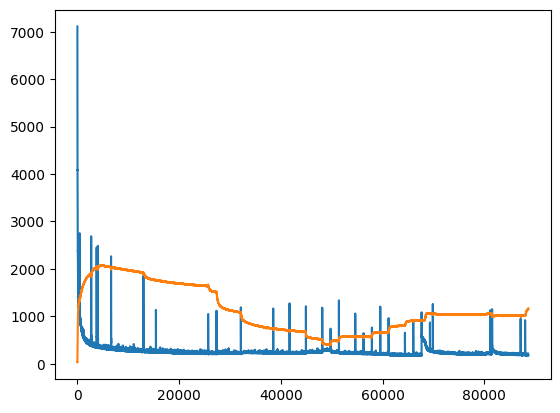

7113.4384765625 178.52857971191406
lr 3e-4, 0.1lpips: 9192.9423828125 4540.0302734375
lr 1e-4, 0.1lpips: 8918.8046875 1402.575927734375
lr 3e-5, 0.1lpips: 9193.6279296875 1534.5819091796875
lr 1e-4, 0.2lpips: 9000.794921875 1412.0052490234375


In [20]:
import glob
import json
from pathlib import Path
import matplotlib.pyplot as plt

# raw_losses = raw_loss_log
SAVE_DIR = Path('checkpoints/vae/topo')
# latest_checkpoint_number = max([
#   int(Path(path).name[len('check'):][:-len('.pt')]) for path in glob.glob('*.pt', root_dir=SAVE_DIR)
# ], default=-1)
# raw_losses = []
# for checkpoint_number in range(latest_checkpoint_number + 1):
#   with open(SAVE_DIR / f'stats{checkpoint_number}.json', 'r') as f:
#     train_stats = json.load(f)
#   raw_losses.extend(train_stats['raw_loss_log'])

stat_files = []
for path in glob.glob('*.json', root_dir=SAVE_DIR):
  epoch_indicator = path[len('stats'):][:-len('.json')]
  if '-' in epoch_indicator:
    start_epoch, end_epoch = [int(epoch_number) for epoch_number in epoch_indicator.split('-')]
  else:
    start_epoch = end_epoch = int(epoch_indicator)
  # with open(SAVE_DIR / path, 'r') as f:
  #   train_stats = json.load(f)train_stats['raw_loss_log']
  stat_files.append((path, start_epoch, end_epoch))
stat_files = sorted(stat_files, key=lambda l: l[1])

kept_paths = []
last_start_epoch, last_end_epoch = -1, -1
for path, start_epoch, end_epoch in stat_files:
  if start_epoch == last_start_epoch:
    if end_epoch > last_end_epoch:
      last_start_epoch, last_end_epoch = start_epoch, end_epoch
  elif start_epoch > last_end_epoch:
    kept_paths.append(path)
    last_start_epoch, last_end_epoch = start_epoch, end_epoch

raw_losses = []
for path in kept_paths:
  with open(SAVE_DIR / path, 'r') as f:
    train_stats = json.load(f)
    raw_losses.extend(train_stats['raw_loss_log'])
print(kept_paths)
# raw_losses = sum([l[1] for l in sorted(raw_losses, key=lambda l: l[0])], [])
  
plt.plot([v[0] for v in raw_losses])
plt.plot([v[1] for v in raw_losses])
# plt.ylim(150, 400)
plt.show()
print(raw_losses[0][0], raw_losses[-1][0])
print('lr 3e-4, 0.1lpips: 9192.9423828125 4540.0302734375')
print('lr 1e-4, 0.1lpips: 8918.8046875 1402.575927734375')
print('lr 3e-5, 0.1lpips: 9193.6279296875 1534.5819091796875')
print('lr 1e-4, 0.2lpips: 9000.794921875 1412.0052490234375')

In [16]:
def defragment_stats(save_dir: Path):
  stat_epochs = []
  for path in glob.glob('*.json', root_dir=save_dir):
    epoch_indicator = path[len('stats'):][:-len('.json')]
    if '-' in epoch_indicator:
      start_epoch, end_epoch = [int(epoch_number) for epoch_number in epoch_indicator.split('-')]
    else:
      start_epoch = end_epoch = int(epoch_indicator)
    stat_epochs.append((path, start_epoch, end_epoch))
  stat_epochs = sorted(stat_epochs, key=lambda l: l[1])

  prev_end = -1
  for _, start_epoch, end_epoch in stat_epochs:
    if start_epoch != prev_end + 1:
      raise ValueError('Break in history!')
    prev_end = end_epoch
  
  defragmented_train_stats = {
    'raw_loss_log': [],
    'weighted_loss_log': [],
    'samples': 0
  }
  for path, start_epoch, end_epoch in stat_epochs:
    with open(SAVE_DIR / path, 'r') as f:
      train_stats = json.load(f)
    defragmented_train_stats['raw_loss_log'].extend(train_stats['raw_loss_log'])
    defragmented_train_stats['weighted_loss_log'].extend(train_stats['weighted_loss_log'])
    defragmented_train_stats['samples'] += train_stats['samples']
  with open(SAVE_DIR / f'stats{0}-{end_epoch}.json', 'w') as f:
    json.dump(defragmented_train_stats, f)
defragment_stats(Path('checkpoints/vae/topo'))

Encoding took 0.012766399999236455s.


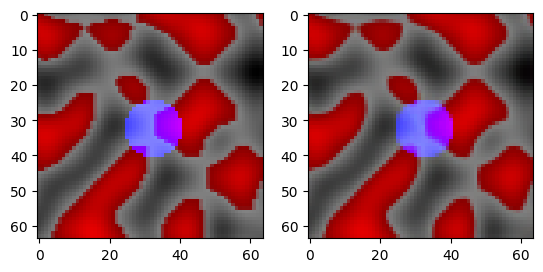

In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt

from experiment.vae import make_vae

# original_image = trainset[4][0].unsqueeze(0)
# load_vae = vae
device = 'cuda'
load_vae = make_vae().to('cuda')
load_vae.load_state_dict(torch.load('checkpoints/vae/topo/check1249.pt'))
testset = nav2d_dataset(1)
testset.transform = transforms.Compose([
  transforms.Normalize((0.5,), (0.5,)),
  # transforms.GaussianBlur(5, 1.0),
  # transforms.GaussianBlur(5, 1.0),
])
original_image = testset[0].unsqueeze(0).to(device)
start_time = time.perf_counter()
load_vae.encode(original_image)
encoding_time = time.perf_counter() - start_time
print(f'Encoding took {encoding_time}s.')
with torch.no_grad():
  reconstructed_image = load_vae.forward_recons(original_image).cpu().numpy().squeeze(0).transpose(1, 2, 0)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(denormalize(original_image).cpu().numpy().squeeze(0).transpose(1, 2, 0))
axes[1].imshow(denormalize(reconstructed_image))

In [6]:
@torch.no_grad()
def convert_checkpoint(path: str):
  device = 'cuda'
  v = make_vae().to(device)
  v.load_state_dict(torch.load(path))

  latents = []
  for images in trainloader:
    images = images.to(device)
    z = v.encode(images)
    latents.append(z)

  std = torch.cat(latents).std()
  print(std)
  # v.latent_scaling_factor = nn.Buffer(torch.ones(1, device=device) / std)
  # torch.save(v.state_dict(), path)

convert_checkpoint('checkpoints/vae/topo/check59.pt')

tensor(2.3777, device='cuda:0')


Encoding took 0.021984799997881055s.


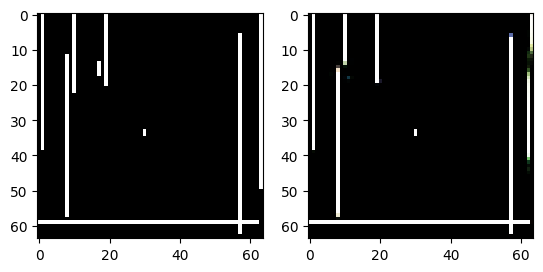

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt

# original_image = trainset[4][0].unsqueeze(0)
# load_vae = vae
device = 'cuda'
load_vae = make_vae().to('cuda')
load_vae.load_state_dict(torch.load('../checkpoints/vae/check57.pt'))
testset = nav2d_dataset(1)
testset.transform = transforms.Compose([
  transforms.Normalize((0.5,), (0.5,)),
  # transforms.GaussianBlur(5, 1.0),
  # transforms.GaussianBlur(5, 1.0),
])
original_image = testset[0].unsqueeze(0).to(device)
start_time = time.perf_counter()
load_vae.encode(original_image)
encoding_time = time.perf_counter() - start_time
print(f'Encoding took {encoding_time}s.')
with torch.no_grad():
  reconstructed_image = load_vae.forward_recons(original_image).cpu().numpy().squeeze(0).transpose(1, 2, 0)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(denormalize(original_image).cpu().numpy().squeeze(0).transpose(1, 2, 0))
axes[1].imshow(denormalize(reconstructed_image))